In [387]:
! pip install imblearn


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [389]:
df_user_engagment = pd.read_csv('takehome_user_engagement 1.csv')

In [390]:
## Sort the data
df_user_engagment.sort_values(['user_id','time_stamp'],inplace=True)

In [391]:
## Check for Nulls/  Missing Values
df_user_engagment.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [392]:
## Checking data types of columns
df_user_engagment.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [393]:
## Convert to timestamp
df_user_engagment['time_stamp'] = pd.to_datetime(df_user_engagment['time_stamp'])

In [394]:
## Find time difference for each user id
df_user_engagment['time_diff'] = df_user_engagment.groupby('user_id')['time_stamp'].diff()

In [395]:
# Checking for days less than 7 days 
df_user_engagment['mark_less_than7'] = df_user_engagment['time_diff'] <= timedelta(days=7)

In [396]:
df_user_engagment['adopted_users'] = df_user_engagment.groupby('user_id')['mark_less_than7'].rolling(window=3).sum().max(level=0) >= 3

C:\Users\sachin.sarathe\AppData\Local\Temp\ipykernel_25328\789860421.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_user_engagment['adopted_users'] = df_user_engagment.groupby('user_id')['mark_less_than7'].rolling(window=3).sum().max(level=0) >= 3


In [397]:
## Dropping columns
df_user_engagment.drop(['time_stamp','visited','time_diff','mark_less_than7'],axis=1,inplace=True)

In [398]:
## Filling Null Values
df_user_engagment['adopted_users'].fillna(False,inplace=True)


In [399]:
## Dropping the duplicates
df_user_engagment.drop_duplicates(inplace=True)

In [401]:
## For user_ids we have multiple sessions because of which some sessions csn be termed as an adopted_user and otherwise for some sessions --> hence handling that in the below code
df_user_engagment_grp = df_user_engagment.groupby('user_id').agg({'adopted_users':'count'}).reset_index()
df_user_engagment_grp['adopted_users'] = df_user_engagment_grp['adopted_users'].map({1:False,2:True})

In [402]:
df_user_engagment_grp

,user_id,adopted_users
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False
...,...,...
8818,11996,False
8819,11997,False
8820,11998,False
8821,11999,False


In [403]:
## Read the other file
df_takehome_users = pd.read_csv('takehome_users 2.csv',encoding='latin-1')

In [404]:
# Check for duplicates
df_takehome_users.duplicated().sum()

0

In [405]:
df_takehome_users.shape

(12000, 10)

In [406]:
df_takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [407]:
## Merge both the dataframes
df_merged = pd.merge(df_takehome_users,df_user_engagment_grp,left_on='object_id', right_on='user_id', how='left')

In [408]:
## Fill Missing Values in column adopted_users with False 
df_merged['adopted_users'] = df_merged['adopted_users'].fillna(False)

In [410]:
## checking for duplicates
print(df_merged.shape)
print(df_merged.duplicated().sum())

(12000, 12)
0


In [411]:
## Checking for adopted_users distribution
df_merged.adopted_users.value_counts()

False    11880
True       120
Name: adopted_users, dtype: int64

### Observations
* Class Imbalance

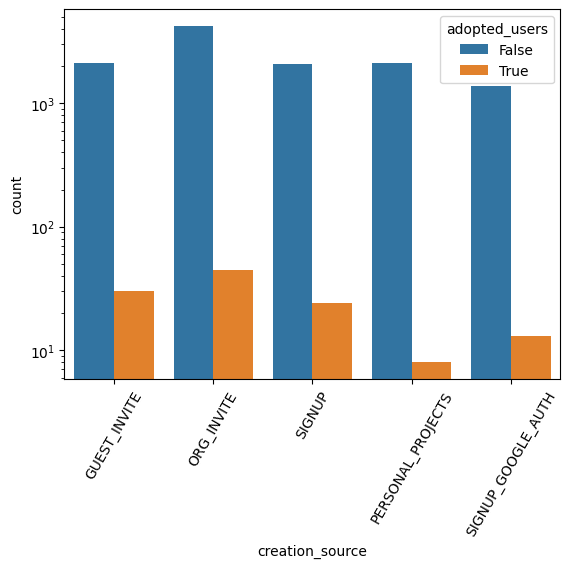

In [412]:
sns.countplot(data=df_merged,x='creation_source',hue='adopted_users')
plt.yscale('log')
plt.xticks(rotation=60)
plt.show()

## Observations :-
* adopted_users are maximum in ORG_INVITE followed by SIGNUP and GUEST_INVITE

In [413]:
df_merged.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'adopted_users'],
      dtype='object')

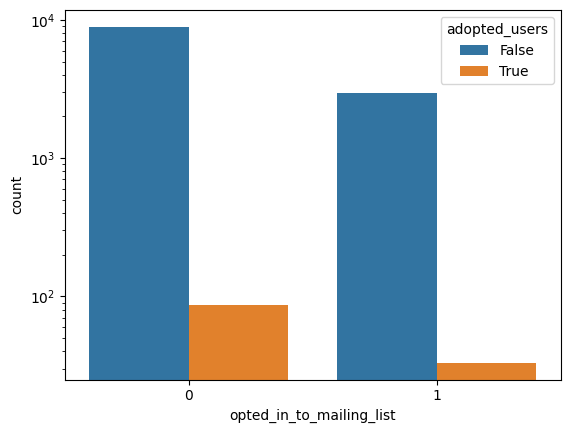

In [414]:
sns.countplot(data=df_merged,x='opted_in_to_mailing_list',hue='adopted_users')
plt.yscale('log')
# plt.xticks(rotation=60)
plt.show()

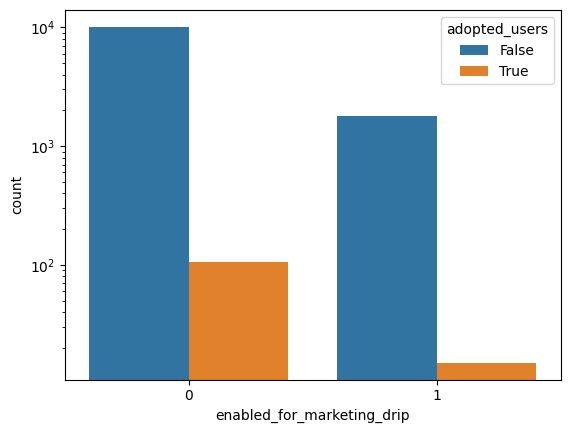

In [415]:
sns.countplot(data=df_merged,x='enabled_for_marketing_drip',hue='adopted_users')
plt.yscale('log')
# plt.xticks(rotation=60)
plt.show()

In [416]:
df_merged.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'adopted_users'],
      dtype='object')

In [417]:
## TimeStamp columns will not be useful so dropping them and also we have some unique ids which also wont be useful
df_merged.drop(['creation_time','last_session_creation_time','user_id','object_id','name','email'],axis=1,inplace=True)

In [418]:
df_merged.columns

Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_users'],
      dtype='object')

In [419]:
## Checking for Nulls
df_merged.isna().sum()

creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_users                    0
dtype: int64

In [420]:
# Filling the column by invited_by_user_id by 0 as a new category since it is a categorical column
df_merged['invited_by_user_id'] = df_merged['invited_by_user_id'].fillna(0)

In [421]:
## The below columns contains many categorical values so that the idea is replace these values by their percentage distribution
org_id_dict = df_merged.org_id.value_counts(normalize=True).to_dict()
invited_by_user_id_dict = df_merged.invited_by_user_id.value_counts(normalize=True).to_dict()

In [422]:
df_merged['org_id'] = df_merged['org_id'].map(org_id_dict)
df_merged['invited_by_user_id'] = df_merged['invited_by_user_id'].map(invited_by_user_id_dict)

In [423]:
df_merged = pd.get_dummies(df_merged,columns=['creation_source'])
df_merged

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,0.006250,0.000083,False,1,0,0,0,0
1,0,0,0.019417,0.000250,True,0,1,0,0,0
2,0,0,0.002667,0.000917,False,0,1,0,0,0
3,0,0,0.019417,0.000583,False,1,0,0,0,0
4,0,0,0.001333,0.000417,False,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0.003333,0.000583,False,0,1,0,0,0
11996,0,0,0.002083,0.465250,False,0,0,0,0,1
11997,1,1,0.002250,0.000417,False,1,0,0,0,0
11998,0,0,0.011500,0.465250,False,0,0,1,0,0


## Train Test Split

In [424]:
# Split the data into features and target
X = df_merged.drop('adopted_users', axis=1)
y = df_merged['adopted_users']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [425]:
# Applying SMOTE oversampling to the training data as we have class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### Model Training

In [426]:
# Train a classifier (Random Forest in this case) on the resampled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2376
        True       0.00      0.00      0.00        24

    accuracy                           0.97      2400
   macro avg       0.49      0.49      0.49      2400
weighted avg       0.98      0.97      0.98      2400

Accuracy: 0.97125


### Feature Importance 

In [428]:
# Extracting feature importances
feature_importances = clf.feature_importances_

# Creating a DataFrame to store and sort feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Printing sorted feature importances
print("Sorted Feature Importances:")
print(feature_importance_df)


Sorted Feature Importances:
                              Feature  Importance
2                              org_id    0.570666
3                  invited_by_user_id    0.321686
1          enabled_for_marketing_drip    0.035386
0            opted_in_to_mailing_list    0.024539
6   creation_source_PERSONAL_PROJECTS    0.019571
4        creation_source_GUEST_INVITE    0.010209
5          creation_source_ORG_INVITE    0.006308
7              creation_source_SIGNUP    0.006295
8  creation_source_SIGNUP_GOOGLE_AUTH    0.005339
